In [1]:
# Enerjisa Hackathon - Exploratory Data Analysis and Data Preparation for Forecast
# 19.04.2022
# Author: Ali Baris Bilen

In [2]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib as mpl
import numpy as np
import seaborn as sns

In [3]:
data_path = pathlib.Path('C:/Users/asus/Desktop/kaggle/enerjisa/')
pd.set_option('display.max_columns', None)

### 1) Power.csv - Exploratory Data Analysis and Forecast Data Prep.

In [4]:
power_df = pd.read_csv(data_path / 'power_cleaned.csv')

In [5]:
power_df.describe()

,power
count,136730.000000
mean,1138.556350
std,1078.419992
min,-48.596700
25%,80.394150
50%,778.220850
75%,2310.443275
max,2779.423300


In [6]:
power_df.dtypes

Timestamp     object
power        float64
dtype: object

In [7]:
# convert to datetime
power_df['Timestamp'] = pd.to_datetime(power_df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

In [8]:
# set index
power_df = power_df.set_index(pd.DatetimeIndex(power_df['Timestamp']))

In [9]:
power_df['Day'] = pd.DatetimeIndex(power_df['Timestamp']).isocalendar()['day']
power_df['Week'] = pd.DatetimeIndex(power_df['Timestamp']).isocalendar()['week']
power_df['Month'] = pd.DatetimeIndex(power_df['Timestamp']).month
power_df['Year'] = pd.DatetimeIndex(power_df['Timestamp']).isocalendar()['year']
power_df['Hour'] = power_df.index.hour

In [10]:
power_df.head(3)

,Timestamp,power,Day,Week,Month,Year,Hour
Timestamp,,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,705.8766,2,1,1,2019,0
2019-01-01 00:10:00,2019-01-01 00:10:00,884.7117,2,1,1,2019,0
2019-01-01 00:20:00,2019-01-01 00:20:00,982.8750,2,1,1,2019,0


In [11]:
power_df.tail(3)

,Timestamp,power,Day,Week,Month,Year,Hour
Timestamp,,,,,,,
2021-08-14 23:30:00,2021-08-14 23:30:00,2759.2434,6,32,8,2021,23
2021-08-14 23:40:00,2021-08-14 23:40:00,2761.2617,6,32,8,2021,23
2021-08-14 23:50:00,2021-08-14 23:50:00,2758.5933,6,32,8,2021,23


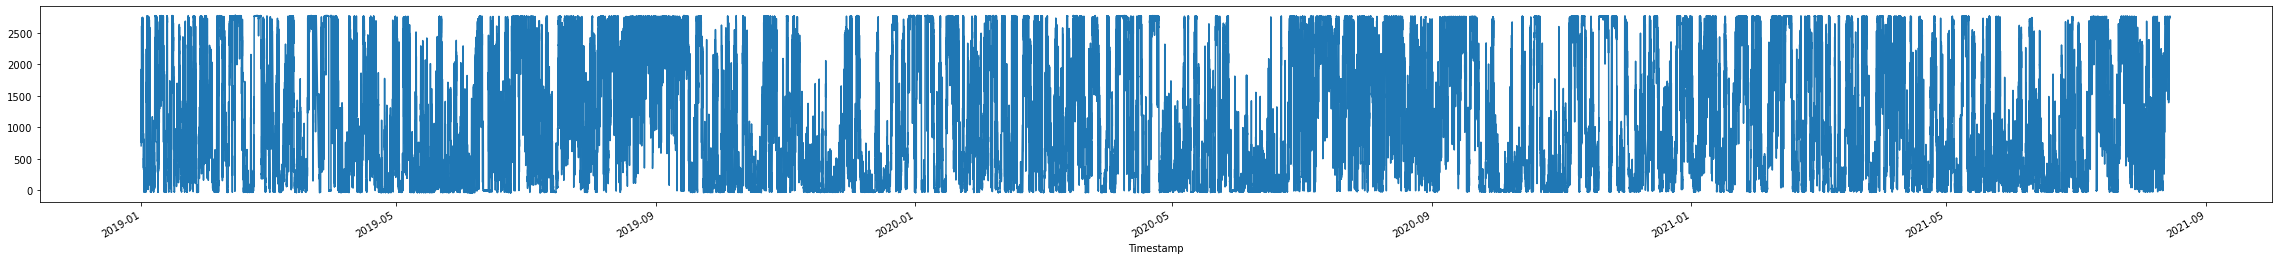

In [12]:
power_df['power'].plot(figsize=(40,4))

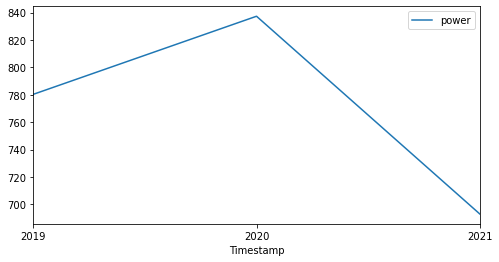

In [13]:
power_df[["power"]].resample("Y").median().plot(figsize=(8,4))

Significant drop in 2021 is meaningless because the observations cover only the first 8 months of the year.

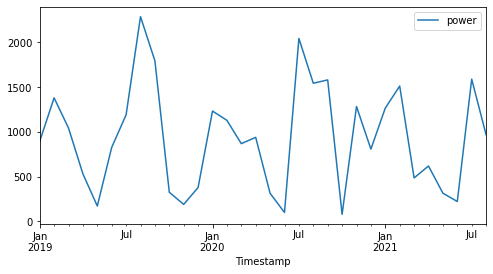

In [14]:
power_df[["power"]].resample("M").median().plot(figsize=(8,4))

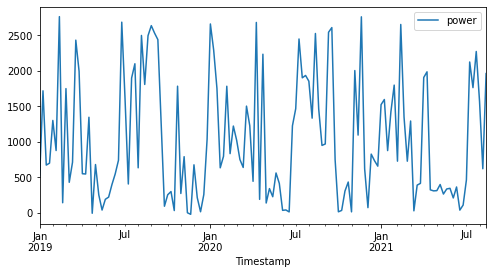

In [15]:
power_df[["power"]].resample("W").median().plot(figsize=(8,4))

Yearly and monthly seasonalities are obvious.

<ipython-input-16-60183b7ad827>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()
<ipython-input-16-60183b7ad827>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


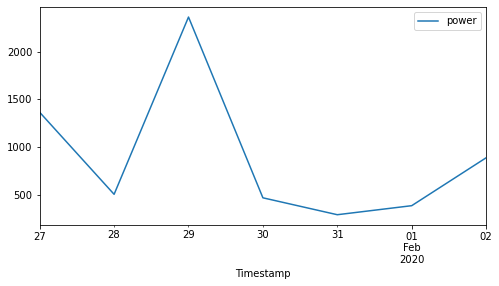

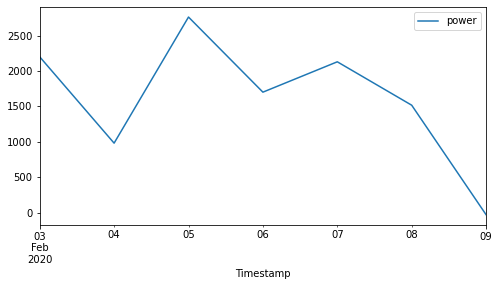

In [16]:
power_df[(power_df['Year'] == 2020) & (power_df['Week'] == 5)][["power"]].resample("D").median().plot(figsize=(8,4))
plt.subplot()
power_df[(power_df['Year'] == 2020) & (power_df['Week'] == 6)][["power"]].resample("D").median().plot(figsize=(8,4))
plt.subplot()
plt.show()

There "may" be also daily seasonality (there is, at least for the given year-week's, but not guaranteed to exhibit the same type of seasonality for every year-week pairs).

In [17]:
only_power_df = pd.DataFrame(power_df.iloc[:,0:2])
only_power_df = only_power_df.set_index('Timestamp').asfreq('W')
only_power_df.index

DatetimeIndex(['2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27',
               '2019-02-03', '2019-02-10', '2019-02-17', '2019-02-24',
               '2019-03-03', '2019-03-10',
               ...
               '2021-06-06', '2021-06-13', '2021-06-20', '2021-06-27',
               '2021-07-04', '2021-07-11', '2021-07-18', '2021-07-25',
               '2021-08-01', '2021-08-08'],
              dtype='datetime64[ns]', name='Timestamp', length=136, freq='W-SUN')

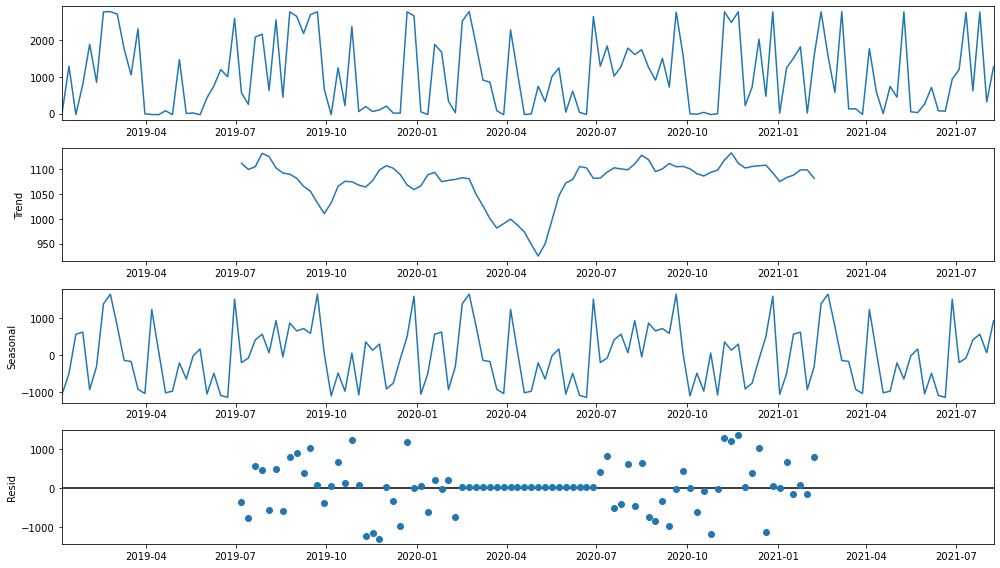

In [18]:
# Investigate decomposed time series
# Decomposition rule = additive
mpl.rcParams['figure.figsize'] = (14, 8)
deseasonalized_series = seasonal_decompose(only_power_df)
deseasonalized_series.plot()
plt.show()

Comments: 
1) Downward trend toward 2020-05 is possibly because of the initial lockdowns in Turkey (it is highly probable that field specialists were at home and turbines are idle, or factories were mostly idle and didn't use power, so wind turbines were shut off). In any case, I don't expect such a sharp decrease in 'trend' (for those months) of the power generation next years.
2) Near-zero residuals during the beginning of the pandemic looks suspicious.
3) Residuals exhibit white noises, which indicates additive decomposition did a good job distinguishing components.

--> We should examine the power generation between 2020-02 & 2020-07 exclusively.

In [19]:
pandemic_beginning_df = pd.DataFrame(power_df.iloc[:,0:2])
pandemic_beginning_df = pandemic_beginning_df.set_index('Timestamp').asfreq('D')
pandemic_beginning_df = pandemic_beginning_df[(pandemic_beginning_df.index > "2020-02-01") & (pandemic_beginning_df.index < "2020-07-01")]

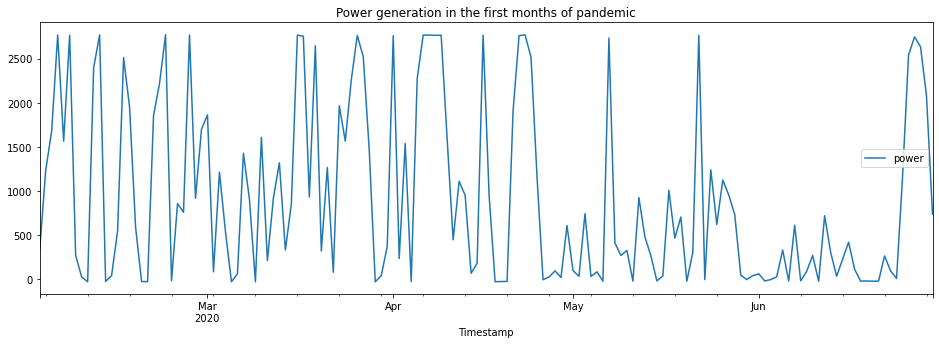

In [20]:
pandemic_beginning_df.plot(figsize=(16,5))
plt.title('Power generation in the first months of pandemic')
plt.show()

In [21]:
pandemic_beginning_df.describe()

,power
count,150.000000
mean,929.539370
std,1006.242429
min,-30.326700
25%,40.122050
50%,543.139150
75%,1602.729150
max,2771.361600


Findings;
1) The mean power generation in this period is 929 kw, while the global mean is 1138. Noted.
2) The series highly fluctuates during summer period (not only for 2020 summer but for 2019 and 2021 summers as well).
3) I don't think there is a problem with seasonality of this period, but I do think the trend might be misleading.
--> I am going to smooth out the downward trend of this period by adding 200 kw to all of the observations between 2020-03 and 2020-06. This will help us eradicate effect of the pandemic on power generation, at least to a certain extent (underlying assumption: pandemic is a one time event and it shouldn't affect our forecasts much). Although a sharp decrease in power generation in the early summer is valid for all years, the average level drops more than enough in 2020 early summer.

In [22]:
power_df[(power_df['Timestamp'] < '2020-06-30') & (power_df['Timestamp'] > '2020-03-01')].head(2)

,Timestamp,power,Day,Week,Month,Year,Hour
Timestamp,,,,,,,
2020-03-01 00:10:00,2020-03-01 00:10:00,2243.3684,7,9,3,2020,0
2020-03-01 00:20:00,2020-03-01 00:20:00,2557.5850,7,9,3,2020,0


In [23]:
power_df['power'] = np.where((power_df['Timestamp'] < '2020-06-30') & (power_df['Timestamp'] > '2020-03-01'),
                             power_df['power'] + 200,
                            power_df['power'])

In [24]:
power_df[(power_df['Timestamp'] < '2020-06-30') & (power_df['Timestamp'] > '2020-03-01')].head(2)

,Timestamp,power,Day,Week,Month,Year,Hour
Timestamp,,,,,,,
2020-03-01 00:10:00,2020-03-01 00:10:00,2443.3684,7,9,3,2020,0
2020-03-01 00:20:00,2020-03-01 00:20:00,2757.5850,7,9,3,2020,0


In [25]:
# test the change
new_pandemic_beginning_df = pd.DataFrame(power_df.iloc[:,0:2])
new_pandemic_beginning_df = new_pandemic_beginning_df.set_index('Timestamp').asfreq('D')
new_pandemic_beginning_df = new_pandemic_beginning_df[(new_pandemic_beginning_df.index > "2020-02-01") & (new_pandemic_beginning_df.index < "2020-07-01")]
new_pandemic_beginning_df.describe()

,power
count,150.000000
mean,1089.539370
std,996.215244
min,-28.740000
25%,237.852050
50%,672.215000
75%,1758.328825
max,2969.701700


+80 increase in mean power generation. Did it really smooth out the downward trend in that period?

In [26]:
# Re-define only_power_df
only_power_df_new = pd.DataFrame(power_df.iloc[:,0:2])
only_power_df_new = only_power_df_new.set_index('Timestamp').asfreq('W')

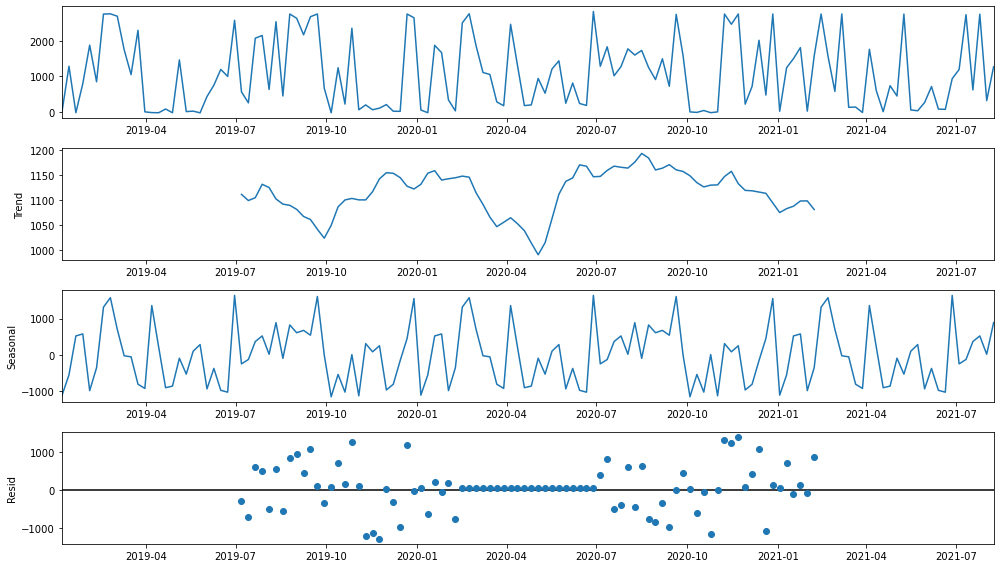

In [27]:
mpl.rcParams['figure.figsize'] = (14, 8)
deseasonalized_series_new = seasonal_decompose(only_power_df_new)
deseasonalized_series_new.plot()
plt.show()

The values are now closer to global mean but that period has still significant downward trend. To make sure, I'll analyze the plot of its 
moving average.

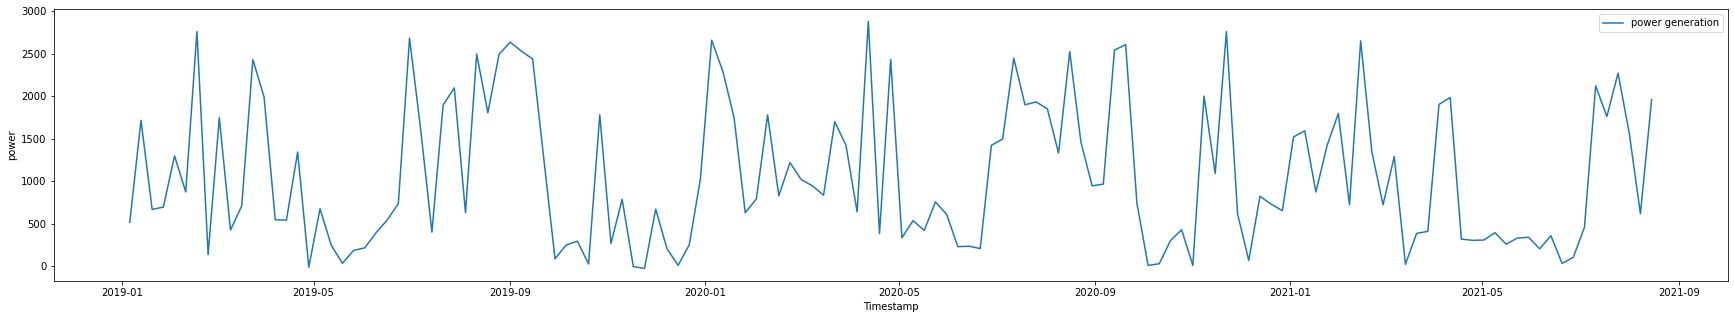

In [28]:
plt.figure(figsize = (30, 5))
  
# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot(x = 'Timestamp',
             y = 'power',
             data = power_df[["power"]].resample("W").median(),
             label = 'power generation')

In [29]:
power_df_for_plot = power_df[["power"]].resample("W").median()

In [30]:
power_df_for_plot.head()

,power
Timestamp,
2019-01-06,517.62840
2019-01-13,1716.51080
2019-01-20,668.93920
2019-01-27,696.67835
2019-02-03,1298.64665


In [31]:
power_df_for_plot['7day_rolling_avg'] = power_df_for_plot.power.rolling(7).mean()

In [32]:
power_df_for_plot.fillna(0)

,power,7day_rolling_avg
Timestamp,,
2019-01-06,517.62840,0.000000
2019-01-13,1716.51080,0.000000
2019-01-20,668.93920,0.000000
2019-01-27,696.67835,0.000000
2019-02-03,1298.64665,0.000000
...,...,...
2021-07-18,1761.20835,721.297036
2021-07-25,2270.90745,1016.316793
2021-08-01,1568.65920,1188.919300


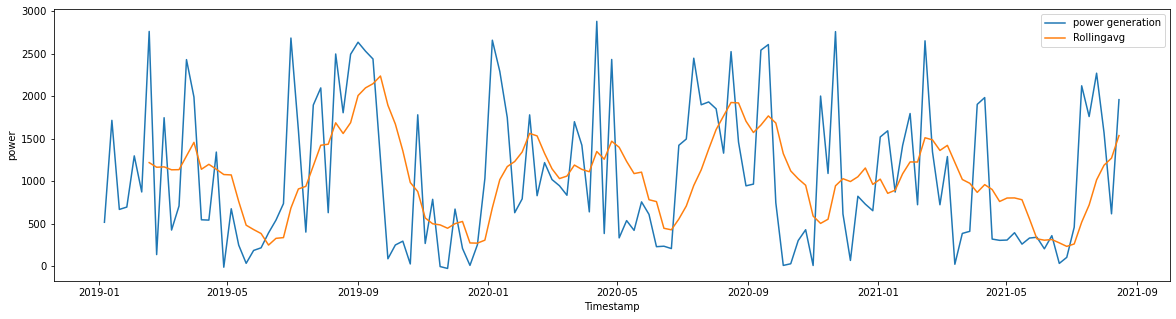

In [33]:
# set figure size
plt.figure(figsize = (20, 5))
  
# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot(x = 'Timestamp',
             y = 'power',
             data = power_df_for_plot,
             label = 'power generation')
  
# plot using rolling average
sns.lineplot(x = 'Timestamp',
             y = '7day_rolling_avg',
             data = power_df_for_plot,
             label = 'Rollingavg')

In [34]:
power_df_for_plot.drop(['7day_rolling_avg'], axis=1, inplace=True)

Early pandemic period seems to be smoothen-out.

---------------------

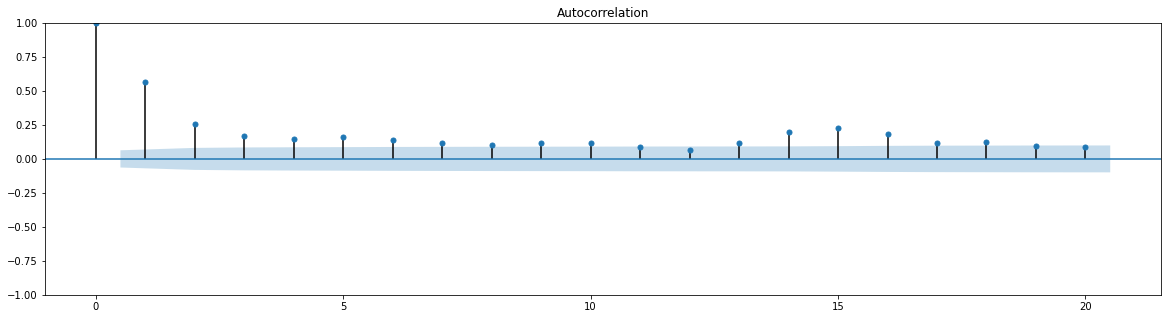

In [35]:
# Checking auto correlations
fig, ax = plt.subplots(figsize = (20,5))
plot_acf(power_df[["power"]].resample("D").median().values.squeeze(), ax = ax, lags = 20) # power_df_for_plot -> aggregated daily
plt.show()

Lag 1, lag 2, lag 3 as well as lag 15 seems to be important. On the other hand, auto correlation plot of the hourly data was not helpful because the auto correlation is super high for such time series with very narrow time intervals.

Four lag features will be added to time series at day level.

In [36]:
def make_lags(ts, lags):
    """
    Creates lag features.
    """
    lagged_df = pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)
    return lagged_df

In [37]:
# Adding lag 2 and lag 3 features "at day level"
power_df_day = pd.DataFrame(power_df.iloc[:,0:2])
power_df_day = power_df_day.set_index('Timestamp').asfreq('D')

In [38]:
power_df_lagged = make_lags(power_df_day.power, lags=3)
power_df_lagged = power_df_lagged.fillna(0.0)

In [39]:
power_df_lagged

,y_lag_1,y_lag_2,y_lag_3
Timestamp,,,
2019-01-01,0.0000,0.0000,0.0000
2019-01-02,705.8766,0.0000,0.0000
2019-01-03,1805.3434,705.8766,0.0000
2019-01-04,38.7683,1805.3434,705.8766
2019-01-05,2429.2026,38.7683,1805.3434
...,...,...,...
2021-08-10,443.0167,1270.5050,2680.7749
2021-08-11,300.1283,443.0167,1270.5050
2021-08-12,157.8433,300.1283,443.0167


In [40]:
temp_power = pd.DataFrame(power_df_day.power)
temp_df = pd.concat([temp_power, temp_power.shift(15)], axis=1)
temp_df.columns = ['power', 'y_lag_15']

In [41]:
temp_df.fillna(0.0, inplace=True)

In [42]:
temp_df.head()

,power,y_lag_15
Timestamp,,
2019-01-01,705.8766,0.0
2019-01-02,1805.3434,0.0
2019-01-03,38.7683,0.0
2019-01-04,2429.2026,0.0
2019-01-05,2548.2134,0.0


In [43]:
power_df_lagged = pd.merge(temp_df, power_df_lagged, left_index=True, right_index=True)

In [44]:
power_df_lagged['Timestamp'] = power_df_lagged.index

In [45]:
power_df_lagged.head()

,power,y_lag_15,y_lag_1,y_lag_2,y_lag_3,Timestamp
Timestamp,,,,,,
2019-01-01,705.8766,0.0,0.0000,0.0000,0.0000,2019-01-01
2019-01-02,1805.3434,0.0,705.8766,0.0000,0.0000,2019-01-02
2019-01-03,38.7683,0.0,1805.3434,705.8766,0.0000,2019-01-03
2019-01-04,2429.2026,0.0,38.7683,1805.3434,705.8766,2019-01-04
2019-01-05,2548.2134,0.0,2429.2026,38.7683,1805.3434,2019-01-05


In [46]:
power_df_lagged['Day'] = pd.DatetimeIndex(power_df_lagged['Timestamp']).isocalendar()['day']
power_df_lagged['Week'] = pd.DatetimeIndex(power_df_lagged['Timestamp']).isocalendar()['week']
power_df_lagged['Month'] = pd.DatetimeIndex(power_df_lagged['Timestamp']).month
power_df_lagged['Year'] = pd.DatetimeIndex(power_df_lagged['Timestamp']).isocalendar()['year']

In [47]:
power_df_lagged

,power,y_lag_15,y_lag_1,y_lag_2,y_lag_3,Timestamp,Day,Week,Month,Year
Timestamp,,,,,,,,,,
2019-01-01,705.8766,0.0000,0.0000,0.0000,0.0000,2019-01-01,2,1,1,2019
2019-01-02,1805.3434,0.0000,705.8766,0.0000,0.0000,2019-01-02,3,1,1,2019
2019-01-03,38.7683,0.0000,1805.3434,705.8766,0.0000,2019-01-03,4,1,1,2019
2019-01-04,2429.2026,0.0000,38.7683,1805.3434,705.8766,2019-01-04,5,1,1,2019
2019-01-05,2548.2134,0.0000,2429.2026,38.7683,1805.3434,2019-01-05,6,1,1,2019
...,...,...,...,...,...,...,...,...,...,...
2021-08-10,300.1283,2210.6968,443.0167,1270.5050,2680.7749,2021-08-10,2,32,8,2021
2021-08-11,157.8433,2597.6782,300.1283,443.0167,1270.5050,2021-08-11,3,32,8,2021
2021-08-12,1007.1967,2576.0632,157.8433,300.1283,443.0167,2021-08-12,4,32,8,2021


In [48]:
power_df

,Timestamp,power,Day,Week,Month,Year,Hour
Timestamp,,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,705.8766,2,1,1,2019,0
2019-01-01 00:10:00,2019-01-01 00:10:00,884.7117,2,1,1,2019,0
2019-01-01 00:20:00,2019-01-01 00:20:00,982.8750,2,1,1,2019,0
2019-01-01 00:30:00,2019-01-01 00:30:00,1115.9434,2,1,1,2019,0
2019-01-01 00:40:00,2019-01-01 00:40:00,1263.8417,2,1,1,2019,0
...,...,...,...,...,...,...,...
2021-08-14 23:10:00,2021-08-14 23:10:00,2757.7283,6,32,8,2021,23
2021-08-14 23:20:00,2021-08-14 23:20:00,2758.3232,6,32,8,2021,23
2021-08-14 23:30:00,2021-08-14 23:30:00,2759.2434,6,32,8,2021,23


Above dataframes will be joined over (Day, Week, Year).

In [49]:
power_df_new = power_df.merge(power_df_lagged, how="inner", on=["Day", "Week", "Year"],
                                                               validate="many_to_one",
                             sort=True, suffixes=(None,"_right"))

In [50]:
power_df_new.head()

,Timestamp,power,Day,Week,Month,Year,Hour,power_right,y_lag_15,y_lag_1,y_lag_2,y_lag_3,Timestamp_right,Month_right
0,2019-12-30 00:00:00,2773.3384,1,1,12,2020,0,2773.3384,11.7967,2657.155,434.78,718.21,2019-12-30,12
1,2019-12-30 00:10:00,2771.2617,1,1,12,2020,0,2773.3384,11.7967,2657.155,434.78,718.21,2019-12-30,12
2,2019-12-30 00:20:00,2769.5801,1,1,12,2020,0,2773.3384,11.7967,2657.155,434.78,718.21,2019-12-30,12
3,2019-12-30 00:30:00,2762.1917,1,1,12,2020,0,2773.3384,11.7967,2657.155,434.78,718.21,2019-12-30,12
4,2019-12-30 00:40:00,2767.9666,1,1,12,2020,0,2773.3384,11.7967,2657.155,434.78,718.21,2019-12-30,12


In [51]:
power_df_new.drop(['power_right', 'Timestamp_right', 'Month_right'], axis=1, inplace=True)

In [52]:
power_df_new.sort_values(by='Timestamp', inplace=True)

In [53]:
power_df_new

,Timestamp,power,Day,Week,Month,Year,Hour,y_lag_15,y_lag_1,y_lag_2,y_lag_3
19259,2019-01-01 00:00:00,705.8766,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000
19260,2019-01-01 00:10:00,884.7117,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000
19261,2019-01-01 00:20:00,982.8750,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000
19262,2019-01-01 00:30:00,1115.9434,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000
19263,2019-01-01 00:40:00,1263.8417,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
111489,2021-08-14 23:10:00,2757.7283,6,32,8,2021,23,1121.615,2565.9551,1007.1967,157.8433
111490,2021-08-14 23:20:00,2758.3232,6,32,8,2021,23,1121.615,2565.9551,1007.1967,157.8433
111491,2021-08-14 23:30:00,2759.2434,6,32,8,2021,23,1121.615,2565.9551,1007.1967,157.8433
111492,2021-08-14 23:40:00,2761.2617,6,32,8,2021,23,1121.615,2565.9551,1007.1967,157.8433


In [54]:
power_df_new.reset_index(drop=True, inplace=True)

In [55]:
# set the index again
power_df_new = power_df_new.set_index(pd.DatetimeIndex(power_df_new['Timestamp']))

In [56]:
power_df_new.head(1)
# This is the ultimate dataframe that will be used in forecasting.

,Timestamp,power,Day,Week,Month,Year,Hour,y_lag_15,y_lag_1,y_lag_2,y_lag_3
Timestamp,,,,,,,,,,,
2019-01-01,2019-01-01,705.8766,2,1,1,2019,0,0.0,0.0,0.0,0.0


--------------------

### 2) Features.csv - Exploratory Data Analysis and Forecast Data Prep.

In [57]:
features_df = pd.read_csv(data_path / 'features_cleaned.csv')

In [58]:
features_df.head(3)

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
0,2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,56.158333,55.000000,55.000000,35.873798,-205.350006,57.0,-212.126663,28.000000,52.618332,264.949768,265.629913,1735.0,16.0,-0.953030,25.0,20.110001,395.029999,17.715000,392.086670,20.0,20.0,392.413330,10.773334,682.044983,11.0,12.0,11.0,72.210175,181.896973,15.140000,0.0,0.0,50.018833,2780.0,395.0,0.0,-0.072567,0.076724,3300.0,0.0,0.0,0.0,24.0,-1.582408,3.976667,-0.761741,0.0,3138.0,0.0,-2.923333,-3.011667,5.909392,2.0,5.957316,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,37.867054,39.281124,5.732657,1.0,5.779913
1,2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,57.000000,55.174999,55.174999,41.370548,-176.223328,57.0,-183.403336,28.000000,53.060001,3.340425,3.055089,1735.0,16.0,-0.971856,25.0,20.424999,396.133331,17.459999,392.931671,20.0,20.0,393.040009,4.976666,683.515015,11.0,12.0,11.0,72.220482,178.224670,14.948334,0.0,0.0,50.006634,2780.0,395.0,0.0,2.632190,0.323242,3300.0,0.0,0.0,0.0,24.0,-2.231261,4.000000,-0.777843,0.0,3138.0,0.0,-3.033333,-2.975000,5.892997,2.0,5.868237,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-90.169106,-89.018669,5.813177,1.0,5.796757
2,2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,57.775002,56.000000,56.000000,44.466202,-105.058334,57.0,-112.143333,28.763334,54.000000,75.649010,75.435135,1735.0,16.0,-0.988937,25.0,21.000000,397.138336,18.000000,394.028320,20.0,20.0,393.941681,0.636667,685.244995,11.0,12.0,11.0,72.364883,184.183014,14.171667,0.0,0.0,49.989101,2780.0,395.0,0.0,2.117626,-0.032209,3300.0,0.0,0.0,0.0,24.0,-2.469615,4.000000,-0.789898,0.0,3138.0,0.0,1.053333,1.028333,5.898009,2.0,5.874691,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-88.556343,-88.422020,5.786413,1.0,5.772958


In [59]:
pd.set_option('display.max_rows', 20)
features_df['Operating State'].unique()

array([16.        , 15.88000011, 14.06499958, ..., 11.37833309,
       15.32220364, 11.42833328])

In [60]:
features_df.describe()

,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
count,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000
mean,910.539255,912.084222,956.578939,932.604123,987.554916,940.773983,910.796711,893.773450,890.011257,883.989709,959.765475,826.008438,941.115536,860.659013,964.799307,895.450812,848.554472,914.108844,995.039454,970.398047,2264.421612,832.319865,892.200339,888.707954,841.432981,1253.012479,910.410684,1293.303281,991.201006,921.454690,1260.038724,1133.573847,1500.021697,904.462752,886.588439,928.390991,1041.774789,1043.357051,836.035239,917.262999,878.691148,989.123826,3647.113165,1430.488341,893.291417,813.145218,848.869979,4106.950292,861.511342,1047.884876,905.617641,812.322926,805.838809,866.965399,783.221803,818.079549,3974.509802,878.690576,899.210231,809.676956,860.865433,935.556258,954.539629,806.168529,813.248516,818.208142,932.959274,951.491410,952.550671,864.845790,885.083909,898.831561,834.060869,795.938805,932.228959,842.631539
std,9176.771328,9133.006680,9478.446948,9318.246090,9435.727145,9295.432993,9313.935323,9105.708255,9062.097127,9073.353077,9399.831788,8762.705800,9534.868518,9054.96953

In [61]:
# Observation #1 -> Those max values (99999) cannot be real, they are certainly because of the sensor error.
features_df[features_df['Gearbox_T1_High_Speed_Shaft_Temperature'] == 99999.000000].head(5)

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
8478,2019-03-01 00:30:00,99999.0,63.241665,56.393333,60.666668,35.233547,60.443333,25.712807,39.783333,52.526669,60.665001,58.476665,58.476665,43.047985,-135.535004,61.0,-147.529999,30.000000,53.058334,-23.994576,-23.532057,1735.0,16.0,-0.984038,26.0,23.139999,401.089996,19.0,398.241669,22.000000,22.0,398.131653,166.244995,692.393311,12.0,13.000000,12.0,74.766281,179.782837,16.059999,0.0,0.0,49.988216,2780.0,398.0,0.0,2.566220,0.198967,3300.0,0.0,0.0,0.0,25.0,-2.549067,6.18,0.670125,0.0,3138.0,0.0,-1.945000,-1.831667,5.875585,2.0,5.865512,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-66.384140,-66.195198,5.798763,1.0,5.798645
8479,2019-03-01 00:40:00,99999.0,62.323334,55.636665,59.884998,47.316895,59.983334,48.373825,37.736668,52.000000,59.884998,57.898335,57.898335,45.570499,-138.273331,61.0,-151.934998,30.000000,52.630001,-334.295502,-334.708099,1735.0,16.0,-0.985802,26.0,23.136667,401.256653,19.0,398.453339,21.540001,22.0,398.283325,165.111664,692.663330,12.0,12.971666,12.0,74.509598,183.123566,16.611666,0.0,0.0,49.993099,2780.0,398.0,0.0,1.781181,0.001520,3300.0,0.0,0.0,0.0,25.0,-2.165051,6.00,0.666977,0.0,3138.0,0.0,0.111667,0.036667,5.844818,2.0,5.805278,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-122.402702,-121.719513,5.886084,1.0,5.859026
8480,2019-03-01 00:50:00,99999.0,62.000000,55.000000,59.000000,39.437576,59.000000,32.805084,36.250000,52.000000,59.000000,57.000000,57.000000,47.302299,-151.789993,61.0,-163.443329,30.000000,52.000000,-321.065979,-321.186218,1735.0,16.0,-0.984165,26.0,23.000000,401.105011,19.0,398.450012,21.000000,22.0,398.274994,166.750000,692.543335,12.0,12.841666,12.0,74.267998,180.799149,16.636667,0.0,0.0,49.998100,2780.0,398.0,0.0,2.803711,0.315022,3300.0,0.0,0.0,0.0,25.0,-2.065737,6.00,0.671528,0.0,3138.0,0.0,-1.405000,-1.361667,5.844081,2.0,5.801718,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-130.302368,-130.402664,5.881614,1.0,5.851178
8481,2019-03-01 01:00:00,99999.0,62.000000,54.884998,59.000000,34.113735,59.000000,52.967987,36.00000

In [62]:
# Let's look at the values of this column right before it is measured as 99999.
features_df.iloc[8476:8479]

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
8476,2019-03-01 00:10:00,64.290001,66.373337,59.243332,63.626667,36.322899,64.083336,28.922789,44.218334,52.313332,63.626667,60.921665,60.921665,55.368317,-180.708328,60.803333,-192.826660,30.0,56.205002,358.804260,357.514404,1735.0,16.0,-0.987621,26.0,25.000000,401.843323,19.748333,398.901672,24.176666,22.0,398.558319,171.211670,693.020020,12.0,12.228333,12.0,75.261993,180.967163,17.000000,0.000063,0.000005,50.022633,2780.0,398.0,0.0,2.454072,0.117937,3300.0,0.0,0.0,0.0,25.0,-1.529440,6.618333,0.683921,0.000033,3138.0,-0.000096,-2.580,-2.501667,5.905737,2.0,5.888865,-0.364223,-0.364223,0.258688,0.104943,0.262820,0.0,0.094872,-0.357675,-78.086555,-78.656693,5.680439,1.0,5.675998
8477,2019-03-01 00:20:00,62.048332,64.693336,57.863335,62.384998,46.316257,62.220001,31.032015,42.273335,53.000000,62.384998,59.731667,59.731667,44.319668,-140.398331,61.000000,-153.244995,30.0,54.431667,130.807510,129.118622,1735.0,16.0,-0.982492,26.0,24.010000,401.291656,19.000000,398.531677,22.559999,22.0,398.108337,166.326660,692.668335,12.0,12.971666,12.0,75.007744,177.645920,16.113333,0.000000,0.000000,49.959099,2780.0,398.0,0.0,3.153350,-0.193616,3300.0,0.0,0.0,0.0,25.0,-1.728069,6.248333,0.670352,0.000000,3138.0,0.000000,0.395,0.310000,5.896317,2.0,5.882266,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-71.339355,-71.687408,5.761026,1.0,5.758421
8478,2019-03-01 00:30:00,99999.000000,63.241665,56.393333,60.666668,35.233547,60.443333,25.712807,39.783333,52.526669,60.665001,58.476665,58.476665,43.047985,-135.535004,61.000000,-147.529999,30.0,53.058334,-23.994576,-23.532057,1735.0,16.0,-0.984038,26.0,23.139999,401.089996,19.000000,398.241669,22.000000,22.0,398.131653,166.244995,692.393311,12.0,13.000000,12.0,74.766281,179.782837,16.059999,0.000000,0.000000,49.988216,2780.0,398.0,0.0,2.566220,0.198967,3300.0,0.0,0.0,0.0,25.0,-2.549067,6.180000,0.670125,0.000000,3138.0,0.000000,-1.945,-1.831667,5.875585,2.0,5.865512,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-66.384140,-66.195198,5.798763,1.0,5.798645


In [63]:
# It should have been around 60-70 degrees.

In [64]:
features_df[(features_df['Gearbox_T1_High_Speed_Shaft_Temperature'] < 90000) & (features_df['Gearbox_T1_High_Speed_Shaft_Temperature'] > 10000)].head(5)

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
24877,2019-06-24 06:10:00,88577.808190,40.121666,38.0,41.994999,22.212093,41.000000,24.638418,30.0,45.0,41.994999,41.000000,41.000000,6.112233,-698.818359,48.0,-714.983337,37.000000,41.000000,-51.056038,-51.226833,1735.000000,16.000000,-0.323535,35.950001,29.621546,388.963348,35.0,386.401672,34.681667,35.560001,387.290009,114.458336,672.758362,32.000000,32.000000,31.0,63.225937,180.068695,27.000000,0.0,0.0,49.993683,2780.0,415.0,0.0,2.216581,-0.204332,3300.0,0.0,0.0,0.0,35.00,-2.178293,24.000000,0.526273,0.0,3147.0,0.0,-1.766667,-1.805000,5.969048,2.000,5.937710,-0.998540,-0.998540,1.015080,0.973708,1.017343,0.000000,0.982195,-1.000000,-83.724937,-84.077393,5.927037,1.000000,5.912678
24878,2019-06-24 06:20:00,87150.159214,40.000000,38.0,42.000000,32.058304,41.000000,15.997175,30.0,45.0,42.000000,41.000000,41.000000,-3.995433,-724.173340,48.0,-736.945007,37.000000,41.000000,34.410923,34.284817,1072.780151,15.376667,-0.567434,35.018333,29.725137,388.651672,35.0,386.091675,34.000000,35.053333,387.066681,106.800003,672.179993,31.670000,31.740000,31.0,63.196102,183.308578,27.000000,0.0,0.0,49.989334,2780.0,415.0,0.0,1.464527,0.006406,3300.0,0.0,0.0,0.0,35.00,-2.390164,24.610001,0.505000,0.0,3147.0,0.0,-3.213333,-3.473333,5.990076,2.095,5.962134,10.279094,10.279094,11.427665,11.404527,11.440440,10.861387,11.420405,10.291721,-77.375565,-77.258514,5.914607,1.863333,5.902673
24879,2019-06-24 06:30:00,85722.510238,40.000000,38.0,41.726665,13.952436,41.000000,18.936913,30.0,45.0,41.726665,41.000000,41.000000,-40.022133,-672.479980,48.0,-678.588318,37.000000,40.798332,5.205906,5.159129,0.000000,12.000000,-0.053034,35.000000,29.828728,389.093323,35.0,386.731659,34.000000,35.084999,387.538330,102.031670,673.015015,31.405001,31.376667,31.0,63.228897,175.151566,27.301666,0.0,0.0,49.967049,2780.0,415.0,0.0,1.906523,0.000000,3300.0,0.0,0.0,0.0,35.00,-2.019390,25.270000,0.491755,0.0,3147.0,0.0,0.670000,0.658333,5.966741,1.000,5.974227,65.004425,65.004425,65.003304,65.002968,65.000000,65.000000,65.000000,65.000000,-13.436844,-13.700368,5.905156,3.000000,5.927134
24880

In [65]:
# Above values also do not make any sense. They should be treated as outliers and they need either to be imputed or removed.

In [66]:
features_df[features_df.Gearbox_T1_High_Speed_Shaft_Temperature > np.percentile(features_df.Gearbox_T1_High_Speed_Shaft_Temperature, float(99))].Gearbox_T1_High_Speed_Shaft_Temperature.unique()

array([9.99990000e+04, 9.85713510e+04, 9.71437020e+04, 9.57160531e+04,
       9.42884041e+04, 9.28607551e+04, 9.14331061e+04, 9.00054572e+04,
       8.85778082e+04, 8.71501592e+04, 8.57225102e+04, 8.42948613e+04,
       8.28672123e+04, 8.14395633e+04, 8.00119143e+04, 7.85842654e+04,
       7.71566164e+04, 7.57289674e+04, 7.43013184e+04, 7.28736695e+04,
       7.14460205e+04, 7.00183715e+04, 6.85907225e+04, 6.71630735e+04,
       6.57354246e+04, 6.43077756e+04, 6.28801266e+04, 6.14524776e+04,
       6.00248287e+04, 5.85971797e+04, 5.71695307e+04, 5.57418817e+04,
       5.43142328e+04, 5.28865838e+04, 5.14589348e+04, 5.00312858e+04,
       4.86036369e+04, 4.71759879e+04, 4.57483389e+04, 4.43206899e+04,
       4.28930410e+04, 4.14653920e+04, 4.00377430e+04, 3.86100940e+04,
       3.71824450e+04, 3.57547961e+04, 3.43271471e+04, 3.28994981e+04,
       3.14718491e+04, 3.00442002e+04, 2.86165512e+04, 2.71889022e+04,
       2.57612532e+04, 2.43336043e+04, 2.29059553e+04, 2.14783063e+04,
      

In [67]:
# Decision: All values that are higher than 99% percentile will be imputed with the last meaningful observation.

In [68]:
def imputer_func_max(df, percentile):
    """
    This function takes a dataframe as input and imputes the observations in this dataframe that are
    higher than the specified percentile with the latest meaningful observation.
    """
    columns = list(df.columns)
    columns.pop(0) # remove timestamp from the list
    for col in columns:
        df[col] = np.where(df[col] > np.percentile(df[col], float(percentile)),
                           float("NaN"), df[col])
            
    df = df.fillna(method='ffill', axis=0)
    return df

In [69]:
import copy
temp_df = copy.deepcopy(features_df) # creating deep copy for testing purposes
imputer_trial = imputer_func_max(temp_df, 99)

In [70]:
# Testing the method.
temp_df.iloc[8476:8479]

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
8476,2019-03-01 00:10:00,64.290001,66.373337,59.243332,63.626667,36.322899,64.083336,28.922789,44.218334,52.313332,63.626667,60.921665,60.921665,55.368317,-180.708328,60.803333,-192.826660,30.0,56.205002,358.804260,357.514404,1735.0,16.0,-0.987621,26.0,25.000000,401.843323,19.748333,398.901672,24.176666,22.0,398.558319,171.211670,693.020020,12.0,12.228333,12.0,75.261993,180.967163,17.000000,0.000063,0.000005,50.022633,2780.0,398.0,0.0,2.454072,0.117937,3300.0,0.0,0.0,0.0,25.0,-1.529440,6.618333,0.683921,0.000033,3138.0,-0.000096,-2.580,-2.501667,5.905737,2.0,5.888865,-0.364223,-0.364223,0.258688,0.104943,0.262820,0.0,0.094872,-0.357675,-78.086555,-78.656693,5.680439,1.0,5.675998
8477,2019-03-01 00:20:00,62.048332,64.693336,57.863335,62.384998,46.316257,62.220001,31.032015,42.273335,53.000000,62.384998,59.731667,59.731667,44.319668,-140.398331,61.000000,-153.244995,30.0,54.431667,130.807510,129.118622,1735.0,16.0,-0.982492,26.0,24.010000,401.291656,19.000000,398.531677,22.559999,22.0,398.108337,166.326660,692.668335,12.0,12.971666,12.0,75.007744,177.645920,16.113333,0.000000,0.000000,49.959099,2780.0,398.0,0.0,3.153350,-0.193616,3300.0,0.0,0.0,0.0,25.0,-1.728069,6.248333,0.670352,0.000000,3138.0,0.000000,0.395,0.310000,5.896317,2.0,5.882266,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-71.339355,-71.687408,5.761026,1.0,5.758421
8478,2019-03-01 00:30:00,NaN,63.241665,56.393333,60.666668,35.233547,60.443333,25.712807,39.783333,52.526669,60.665001,58.476665,58.476665,43.047985,-135.535004,61.000000,-147.529999,30.0,53.058334,-23.994576,-23.532057,1735.0,16.0,-0.984038,26.0,23.139999,401.089996,19.000000,398.241669,22.000000,22.0,398.131653,166.244995,692.393311,12.0,13.000000,12.0,74.766281,179.782837,16.059999,0.000000,0.000000,49.988216,2780.0,398.0,0.0,2.566220,0.198967,3300.0,0.0,0.0,0.0,25.0,-2.549067,6.180000,0.670125,0.000000,3138.0,0.000000,-1.945,-1.831667,5.875585,2.0,5.865512,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-66.384140,-66.195198,5.798763,1.0,5.798645


In [71]:
imputer_trial.iloc[8476:8479]
# Seems fine.

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
8476,2019-03-01 00:10:00,64.290001,66.373337,59.243332,63.626667,36.322899,64.083336,28.922789,44.218334,52.313332,63.626667,60.921665,60.921665,55.368317,-180.708328,60.803333,-192.826660,30.0,56.205002,358.804260,357.514404,1735.0,16.0,-0.987621,26.0,25.000000,401.843323,19.748333,398.901672,24.176666,22.0,398.558319,171.211670,693.020020,12.0,12.228333,12.0,75.261993,180.967163,17.000000,0.000063,0.000005,50.022633,2780.0,398.0,0.0,2.454072,0.117937,3300.0,0.0,0.0,0.0,25.0,-1.529440,6.618333,0.683921,0.000033,3138.0,-0.000096,-2.580,-2.501667,5.905737,2.0,5.888865,-0.364223,-0.364223,0.258688,0.104943,0.262820,0.0,0.094872,-0.357675,-78.086555,-78.656693,5.680439,1.0,5.675998
8477,2019-03-01 00:20:00,62.048332,64.693336,57.863335,62.384998,46.316257,62.220001,31.032015,42.273335,53.000000,62.384998,59.731667,59.731667,44.319668,-140.398331,61.000000,-153.244995,30.0,54.431667,130.807510,129.118622,1735.0,16.0,-0.982492,26.0,24.010000,401.291656,19.000000,398.531677,22.559999,22.0,398.108337,166.326660,692.668335,12.0,12.971666,12.0,75.007744,177.645920,16.113333,0.000000,0.000000,49.959099,2780.0,398.0,0.0,3.153350,-0.193616,3300.0,0.0,0.0,0.0,25.0,-1.728069,6.248333,0.670352,0.000000,3138.0,0.000000,0.395,0.310000,5.896317,2.0,5.882266,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-71.339355,-71.687408,5.761026,1.0,5.758421
8478,2019-03-01 00:30:00,62.048332,63.241665,56.393333,60.666668,35.233547,60.443333,25.712807,39.783333,52.526669,60.665001,58.476665,58.476665,43.047985,-135.535004,61.000000,-147.529999,30.0,53.058334,-23.994576,-23.532057,1735.0,16.0,-0.984038,26.0,23.139999,401.089996,19.000000,398.241669,22.000000,22.0,398.131653,166.244995,692.393311,12.0,13.000000,12.0,74.766281,179.782837,16.059999,0.000000,0.000000,49.988216,2780.0,398.0,0.0,2.566220,0.198967,3300.0,0.0,0.0,0.0,25.0,-2.549067,6.180000,0.670125,0.000000,3138.0,0.000000,-1.945,-1.831667,5.875585,2.0,5.865512,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-66.384140,-66.195198,5.798763,1.0,5.798645


In [72]:
display(features_df.isnull().sum())

Timestamp                                          0
Gearbox_T1_High_Speed_Shaft_Temperature            0
Gearbox_T3_High_Speed_Shaft_Temperature            0
Gearbox_T1_Intermediate_Speed_Shaft_Temperature    0
Temperature Gearbox Bearing Hollow Shaft           0
                                                  ..
Moment Q Direction                                 0
Moment Q Filltered                                 0
Proxy Sensor_Degree-45                             0
Turbine State                                      0
Proxy Sensor_Degree-315                            0
Length: 77, dtype: int64

In [73]:
features_df.iloc[8476:8479]

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
8476,2019-03-01 00:10:00,64.290001,66.373337,59.243332,63.626667,36.322899,64.083336,28.922789,44.218334,52.313332,63.626667,60.921665,60.921665,55.368317,-180.708328,60.803333,-192.826660,30.0,56.205002,358.804260,357.514404,1735.0,16.0,-0.987621,26.0,25.000000,401.843323,19.748333,398.901672,24.176666,22.0,398.558319,171.211670,693.020020,12.0,12.228333,12.0,75.261993,180.967163,17.000000,0.000063,0.000005,50.022633,2780.0,398.0,0.0,2.454072,0.117937,3300.0,0.0,0.0,0.0,25.0,-1.529440,6.618333,0.683921,0.000033,3138.0,-0.000096,-2.580,-2.501667,5.905737,2.0,5.888865,-0.364223,-0.364223,0.258688,0.104943,0.262820,0.0,0.094872,-0.357675,-78.086555,-78.656693,5.680439,1.0,5.675998
8477,2019-03-01 00:20:00,62.048332,64.693336,57.863335,62.384998,46.316257,62.220001,31.032015,42.273335,53.000000,62.384998,59.731667,59.731667,44.319668,-140.398331,61.000000,-153.244995,30.0,54.431667,130.807510,129.118622,1735.0,16.0,-0.982492,26.0,24.010000,401.291656,19.000000,398.531677,22.559999,22.0,398.108337,166.326660,692.668335,12.0,12.971666,12.0,75.007744,177.645920,16.113333,0.000000,0.000000,49.959099,2780.0,398.0,0.0,3.153350,-0.193616,3300.0,0.0,0.0,0.0,25.0,-1.728069,6.248333,0.670352,0.000000,3138.0,0.000000,0.395,0.310000,5.896317,2.0,5.882266,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-71.339355,-71.687408,5.761026,1.0,5.758421
8478,2019-03-01 00:30:00,99999.000000,63.241665,56.393333,60.666668,35.233547,60.443333,25.712807,39.783333,52.526669,60.665001,58.476665,58.476665,43.047985,-135.535004,61.000000,-147.529999,30.0,53.058334,-23.994576,-23.532057,1735.0,16.0,-0.984038,26.0,23.139999,401.089996,19.000000,398.241669,22.000000,22.0,398.131653,166.244995,692.393311,12.0,13.000000,12.0,74.766281,179.782837,16.059999,0.000000,0.000000,49.988216,2780.0,398.0,0.0,2.566220,0.198967,3300.0,0.0,0.0,0.0,25.0,-2.549067,6.180000,0.670125,0.000000,3138.0,0.000000,-1.945,-1.831667,5.875585,2.0,5.865512,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-66.384140,-66.195198,5.798763,1.0,5.798645


The method works fine. Let's apply it to our main dataframe.

In [74]:
features_df_new = imputer_func_max(features_df, 99)

In [75]:
features_df_new.iloc[8476:8479]

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
8476,2019-03-01 00:10:00,64.290001,66.373337,59.243332,63.626667,36.322899,64.083336,28.922789,44.218334,52.313332,63.626667,60.921665,60.921665,55.368317,-180.708328,60.803333,-192.826660,30.0,56.205002,358.804260,357.514404,1735.0,16.0,-0.987621,26.0,25.000000,401.843323,19.748333,398.901672,24.176666,22.0,398.558319,171.211670,693.020020,12.0,12.228333,12.0,75.261993,180.967163,17.000000,0.000063,0.000005,50.022633,2780.0,398.0,0.0,2.454072,0.117937,3300.0,0.0,0.0,0.0,25.0,-1.529440,6.618333,0.683921,0.000033,3138.0,-0.000096,-2.580,-2.501667,5.905737,2.0,5.888865,-0.364223,-0.364223,0.258688,0.104943,0.262820,0.0,0.094872,-0.357675,-78.086555,-78.656693,5.680439,1.0,5.675998
8477,2019-03-01 00:20:00,62.048332,64.693336,57.863335,62.384998,46.316257,62.220001,31.032015,42.273335,53.000000,62.384998,59.731667,59.731667,44.319668,-140.398331,61.000000,-153.244995,30.0,54.431667,130.807510,129.118622,1735.0,16.0,-0.982492,26.0,24.010000,401.291656,19.000000,398.531677,22.559999,22.0,398.108337,166.326660,692.668335,12.0,12.971666,12.0,75.007744,177.645920,16.113333,0.000000,0.000000,49.959099,2780.0,398.0,0.0,3.153350,-0.193616,3300.0,0.0,0.0,0.0,25.0,-1.728069,6.248333,0.670352,0.000000,3138.0,0.000000,0.395,0.310000,5.896317,2.0,5.882266,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-71.339355,-71.687408,5.761026,1.0,5.758421
8478,2019-03-01 00:30:00,62.048332,63.241665,56.393333,60.666668,35.233547,60.443333,25.712807,39.783333,52.526669,60.665001,58.476665,58.476665,43.047985,-135.535004,61.000000,-147.529999,30.0,53.058334,-23.994576,-23.532057,1735.0,16.0,-0.984038,26.0,23.139999,401.089996,19.000000,398.241669,22.000000,22.0,398.131653,166.244995,692.393311,12.0,13.000000,12.0,74.766281,179.782837,16.059999,0.000000,0.000000,49.988216,2780.0,398.0,0.0,2.566220,0.198967,3300.0,0.0,0.0,0.0,25.0,-2.549067,6.180000,0.670125,0.000000,3138.0,0.000000,-1.945,-1.831667,5.875585,2.0,5.865512,-0.366048,-0.366048,0.259753,0.105179,0.262752,0.0,0.094833,-0.357584,-66.384140,-66.195198,5.798763,1.0,5.798645


Good. <br>
Now, we better look run .describe() again.

In [76]:
features_df_new.describe()

,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
count,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000
mean,53.040337,54.932929,49.501636,53.412139,65.986536,53.473881,35.255205,40.048171,61.410843,53.387174,51.726110,51.753009,23.365974,34.289318,67.598306,17.500427,37.256784,47.167309,125.776221,125.849666,1447.870895,15.335025,0.222905,32.661034,27.471874,400.111283,29.057958,397.122631,59.192673,31.375992,396.776573,225.365906,676.706024,23.053011,23.329974,23.003080,88.820798,176.219268,23.982047,0.001541,0.000057,49.967132,2773.290032,524.532331,0.342067,-0.392947,-0.005441,3299.882041,-0.007009,131.519777,-0.013719,31.439989,-1.905517,16.613778,0.147413,-0.001013,3150.804275,-0.000528,0.074288,-0.081511,5.885381,13.951019,33.261499,12.145360,12.079421,13.189368,12.869432,43.187920,13.048102,13.166453,12.646771,-9.231388,-9.788344,5.777732,2.678522,5.800035
std,12.611248,12.586427,10.779393,9.666699,169.986268,11.837183,24.595030,13.887138,14.787001,10.494551,10.173813,9.281253,91.096398,286.391330,14.633957,278.971759,7.992218,9.704424,184.589974,184.017300,628.314404,1.494962,0.836405,7.565091,6.894320

We should also apply a similar procedure for minimum values. Again, those non-sense values (-273 C, i.e. absolute zero) should have <br>
originated in data collection phase.

In [77]:
def imputer_func_min(df, percentile):
    """
    This function takes a dataframe as input and imputes the observations in this dataframe that are
    higher than the specified percentile with the latest meaningful observation.
    Minimum version of imputer_func_max().
    """
    columns = list(df.columns)
    columns.pop(0) # remove timestamp from the list
    for col in columns:
        df[col] = np.where(df[col] < np.percentile(df[col], float(percentile)),
                           float("NaN"), df[col])
            
    df = df.fillna(method='ffill', axis=0)
    return df

In [78]:
features_df_new = imputer_func_min(features_df_new, 0.1) # why 0.05? Because 0.01 or 0.02 didn't suffice to eradicate those outliers.

In [79]:
features_df_new.describe()

,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
count,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.0,154262.0,154262.000000,154262.0,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000
mean,53.119017,54.986961,49.555494,53.413194,65.986536,53.525945,35.255205,40.101078,61.441931,53.438509,51.778132,51.756830,23.365974,34.486549,67.633552,17.718594,37.309874,47.220695,126.140833,126.213928,1447.870895,15.335327,0.222905,32.712973,27.521596,400.315362,29.061540,397.309686,59.196032,31.377391,396.979267,225.365906,676.706024,23.055819,23.336624,23.007478,88.866796,176.258643,23.983048,0.001556,0.000061,49.992668,2773.290084,524.532331,0.342067,1.537555,-0.002835,3300.0,0.0,131.526396,0.0,31.443291,-1.899303,16.660915,0.147549,-0.000651,3150.804275,-0.000327,0.142916,-0.009091,5.886503,13.951019,33.262637,12.594623,12.528684,13.553951,13.273470,43.187927,13.048102,13.167187,12.646859,-8.866340,-9.380638,5.779104,2.678522,5.801423
std,11.741908,11.865758,9.955564,9.662931,169.986268,11.076639,24.595030,13.293485,14.745966,9.630534,9.288211,9.242255,91.096398,285.688862,14.585653,278.193470,6.932296,8.789892,180.807369,180.224142,628.314404,1.493727,0.836405,6.472475,5.723344,4.660265,6.722772,4.369013,881.2015

* I'm going to remove some of the columns which I think they are very unlikely to provide us any predictive power, from the dataset.

In [80]:
# One manual imputation
features_df_new['Tower Accelaration Normal Raw'] = np.where((features_df_new['Tower Accelaration Normal Raw'] < -5),
                           0,
                           features_df_new['Tower Accelaration Normal Raw'])

In [81]:
# check
features_df_new[features_df_new['Tower Accelaration Normal Raw'] == 0].shape[0] # good.

395

In [82]:
features_df_new.drop(['Operating State', 'Line Frequency',
                      'Blade-2 Actual Value_Angle-B',
                      'Blade-1 Actual Value_Angle-B',
                      'Blade-3 Actual Value_Angle-B',
                      'Pitch Offset-1 Asymmetric Load Controller',
                      'Proxy Sensor_Degree-135',
                      'Proxy Sensor_Degree-225',
                      'Proxy Sensor_Degree-315',
                      'Proxy Sensor_Degree-45'], axis=1, inplace=True)

# Why these columns?
# -> I've checked the diagnostics of these columns and I think that the information stored in these columns is a bit sparse, and will
# barely help us predict the dependent variable. To avoid incurring additional variance brought by these columns, I simply give up on them.

In [83]:
# final check
features_df_new.isnull().values.any() # NA free.

False

### 3) Conclude the notebook

In [84]:
power_df_new.head(1)

,Timestamp,power,Day,Week,Month,Year,Hour,y_lag_15,y_lag_1,y_lag_2,y_lag_3
Timestamp,,,,,,,,,,,
2019-01-01,2019-01-01,705.8766,2,1,1,2019,0,0.0,0.0,0.0,0.0


In [85]:
power_df_new.isnull().values.any() # NA free.

False

In [86]:
features_df_new.head(1)

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,State and Fault,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Turbine State
0,2019-01-01 00:00:00,57.0,59.0,52.0,56.158333,47.053776,57.0,18.890772,35.0,48.576668,56.158333,55.0,55.0,35.873798,-205.350006,57.0,-212.126663,28.0,52.618332,264.949768,265.629913,1735.0,-0.95303,25.0,20.110001,395.029999,17.715,392.08667,20.0,20.0,392.41333,10.773334,682.044983,11.0,12.0,11.0,72.210175,181.896973,15.14,0.0,0.0,2780.0,395.0,0.0,-0.072567,0.076724,3300.0,24.0,-1.582408,3.976667,-0.761741,3138.0,0.0,-2.923333,-3.011667,2.0,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,37.867054,39.281124,1.0


In [87]:
# set index to feature dataframe
features_df_new = features_df_new.set_index(pd.DatetimeIndex(features_df_new['Timestamp']))

In [88]:
# Join two two dataframes and obtain training data
train_df = pd.merge(power_df_new, features_df_new, left_index=True, right_index=True)

In [89]:
train_df

,Timestamp_x,power,Day,Week,Month,Year,Hour,y_lag_15,y_lag_1,y_lag_2,y_lag_3,Timestamp_y,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,State and Fault,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Turbine State
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,705.8766,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,56.158333,55.000000,55.000000,35.873798,-205.350006,57.0,-212.126663,28.000000,52.618332,264.949768,265.629913,1735.0,-0.953030,25.0,20.110001,395.029999,17.715000,392.086670,20.000000,20.000000,392.413330,10.773334,682.044983,11.0,12.0,11.0,72.210175,181.896973,15.140000,0.000000,0.000000,2780.0,395.0,0.0,-0.072567,0.076724,3300.0,24.000000,-1.582408,3.976667,-0.761741,3138.0,0.000000,-2.923333,-3.011667,2.0,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.000000,0.058617,-0.325738,37.867054,39.281124,1.0
2019-01-01 00:10:00,2019-01-01 00:10:00,884.7117,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,57.000000,55.174999,55.174999,41.370548,-176.223328,57.0,-183.403336,28.000000,53.060001,3.340425,3.055089,1735.0,-0.971856,25.0,20.424999,396.133331,17.459999,392.931671,20.000000,20.000000,393.040009,4.976666,683.515015,11.0,12.0,11.0,72.220482,178.224670,14.948334,0.000000,0.000000,2780.0,395.0,0.0,2.632190,0.323242,3300.0,24.000000,-2.231261,4.000000,-0.777843,3138.0,0.000000,-3.033333,-2.975000,2.0,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.000000,0.058617,-0.325738,-90.169106,-89.018669,1.0
2019-01-01 00:20:00,2019-01-01 00:20:00,982.8750,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,57.775002,56.000000,56.000000,44.466202,-105.058334,57.0,-112.143333,28.763334,54.000000,75.649010,75.435135,1735.0,-0.988937,25.0,21.000000,397.138336,18.000000,394.028320,20.000000,20.000000,393.941681,0.636667,685.244995,11.0,12.0,11.0,72.364883,184.183014,14.171667,0.000000,0.000000,2780.0,395.0,0.0,2.117626,-0.032209,3300.0,24.000000,-2.469615,4.000000,-0.789898,3138.0,0.000000,1.053333,1.028333,2.0,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.000000,0.058617,-0.325738,-88.556343,-88.422020,1.0
2019-01-01 00:30:00,2019-01-01 00:30:00,1115.94

In [90]:
future_features_df = features_df_new[features_df_new['Timestamp'] > "2021-08-14 23:50:00"]

In [91]:
features_df_new.shape[0] - train_df.shape[0] == future_features_df.shape[0] # check if there is any data leakage.

True

In [92]:
# Reduce the number of digits after decimal point to four, in order to reduce the computational burden.
train_df = train_df.round(4)
future_features_df = future_features_df.round(4)

In [93]:
train_df.drop(['Timestamp_y'], axis=1, inplace=True)

In [94]:
train_df.rename({'Timestamp_x':'Timestamp'}, axis=1, inplace=True)

In [95]:
# Files to be used in forecasting

train_df.to_csv(path_or_buf = data_path / 'training_data.csv', index=False,
                header=True)

future_features_df.to_csv(path_or_buf = data_path / 'future_features.csv', index=False,
                header=True)

In [98]:
# End